# Advance HPC - Labwork 3

## Requirements

Make image RGB-to-gray converter using Numba CUDA

- Load an image from file (matplotlib’s imread)
- Flatten image into 1D array of RGB (`reshape(pixelCount, 3)`)
- Implement grayscale using CPU (for range)
- Implement grayscale using GPU
- Save/show the image after each grayscale to validate the result visually
- Use `time.time()` to measure speedup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import time

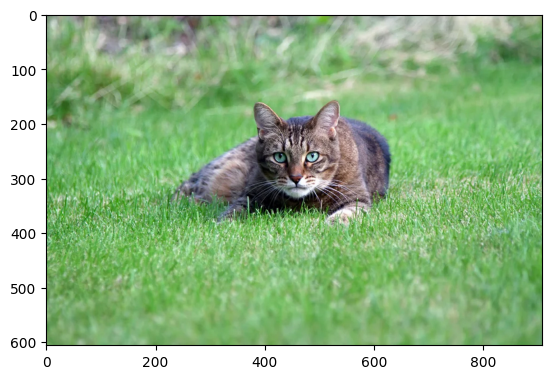

In [2]:
# load image
img = imread("original.png")
imgplot = plt.imshow(img)
plt.show()

In [3]:
img.shape

(606, 909, 4)

## Using CPU

Time: 1.8062183856964111 seconds


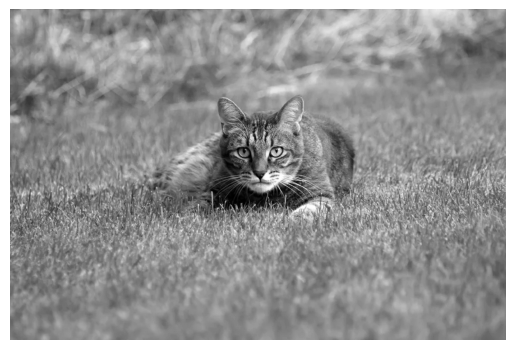

In [4]:
start = time.time()
# flatten the image
h, w, c = img.shape
pixel_count = h * w
rgb = img[..., :3].reshape(pixel_count, 3) # ignore alpha channel, so use :3

# convert to grayscale
def grayscale_cpu(r: int,g: int, b: int) -> int:
	return (r + g + b) / 3

grayscale_array = np.zeros((pixel_count, 1))
for i in range(pixel_count):
    r, g, b = rgb[i]
    grayscale = grayscale_cpu(r, g, b)
    grayscale_array[i] = grayscale

grayscale_img = grayscale_array.reshape(h, w)
end = time.time()
print(f"Time: {end - start} seconds")

fig = plt.figure()
plt.imshow(grayscale_img, cmap='gray')
plt.axis('off')
plt.show()
plt.imsave("grayscale_cpu.png", grayscale_img, cmap='gray')
plt.close(fig)

## Using GPU

In [5]:
from numba import cuda, float32

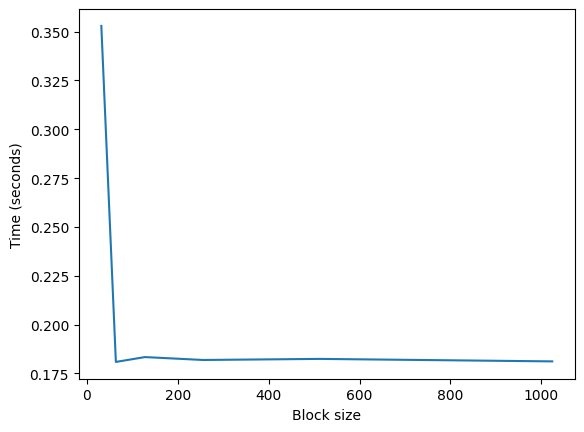

In [11]:
start = time.time()

@cuda.jit
def grayscale_kernel(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.float32((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g
    # dst[tidx] = g

def to_grayscale_gpu(img, block_size: int, kernel, show_result: bool = False):
    h, w, c = img.shape
    pixel_count = h * w
    grid_size = pixel_count // block_size + 1
    rgb = np.ascontiguousarray(img[..., :3].reshape(pixel_count, 3))

    devSrc = cuda.to_device(rgb)
    devDst = cuda.device_array((pixel_count, 3), dtype=np.float32)

    kernel[grid_size, block_size](devSrc, devDst)

    hostDst = devDst.copy_to_host()
    grayscale_img = hostDst.reshape(h, w, 3)
    # Display the grayscale image
    fig = plt.figure()
    plt.imshow(grayscale_img, cmap='gray')
    if show_result:
        plt.axis('off')
        plt.show()
    plt.imsave(f"grayscale_gpu_block_size_{block_size}.png", grayscale_img, cmap='gray')
    plt.close(fig)

block_sizes_to_test = [32, 64, 128, 256, 512, 1024]
time_results = []
for block_size in block_sizes_to_test:
    start = time.time()
    to_grayscale_gpu(img, block_size, grayscale_kernel, show_result=False)
    end = time.time()
    time_results.append(end - start)

fig = plt.figure()
plt.plot(block_sizes_to_test, time_results)
plt.xlabel("Block size")
plt.ylabel("Time (seconds)")
plt.show()
fig.savefig("block_size_vs_time.png", bbox_inches='tight')